In [1]:
import soundfile
import os, pickle
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import torch
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import librosa
from model import LSTM_fixed_len as model
from model import Trainer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
device = torch.device('cuda:3')

In [3]:
#set up trainer
model_dump = "project_models/" 
trainer = Trainer(device, dump_folder=model_dump) 

In [4]:
def extract_feature(file_name):
    #https://github.com/terranivium/speech-emotion-recognition/blob/master/speech_emotion_recognition.ipynb
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32") # all depth 32bit float
        sample_rate = sound_file.samplerate # always 16kHz
        
        # pre-emphasis
        pre_emphasis = 0.97
        X = np.append(X[0], X[1:] - pre_emphasis * X[:-1])

        # remove silence
        y = librosa.effects.split(X, top_db=20)
        l = []
        for i in y:
            l.append(X[i[0]:i[1]] )
        X = np.concatenate(l, axis=0)
        
        # extract features
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        n_fft=int(0.500*sample_rate)
        mfccs=np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=40,
                                            power=2.0,
                                            window = 'hamming',
                                            fmin = 0,
                                            fmax = 8000,
                                            #n_fft=sr,
                                            #win_length=n_fft,
                                            center=True).T,axis=0)
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((mfccs, chroma))
    result = np.hstack((result, mel))
    return result

In [5]:
emotions={
  0:'neutral',
  1:'calm',
  2:'happy',
  3:'sad',
  4:'angry',
  5:'fearful',
  6:'disgust',
  7:'surprised'
}
target_names = list(emotions.keys())
target_emotions = list(emotions.values())

In [6]:
X,y=[],[]
all_files = Path("Audio_Speech_Actors_01-24")

for file in all_files.glob("Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = basename.split("-")[2]
    emotion = emotion.replace('0','')
    emotion = int(emotion)-1
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    y.append(emotion)

In [7]:
x = torch.Tensor(X)
x.shape

torch.Size([1440, 180])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1765, random_state=3)

In [9]:
x_train, x_test, x_val, y_train, y_test, y_val = torch.Tensor(x_train), torch.Tensor(x_test), torch.Tensor(x_val), torch.LongTensor(y_train),  torch.LongTensor(y_test), torch.LongTensor(y_val)

In [10]:
x_train.shape

torch.Size([1007, 180])

In [11]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


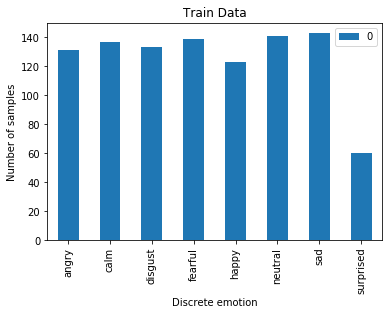

In [12]:
y_train_ct = Counter(y_train.tolist())

keys = [emotions[y] for y in list(y_train_ct.keys())]
data = y_train_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Train Data")
plt.show()

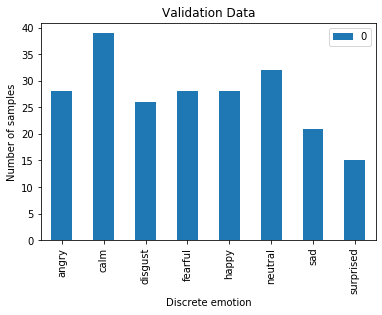

In [13]:
y_val_ct = Counter(y_val.tolist())

keys = [emotions[y] for y in list(y_val_ct.keys())]
data = y_val_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Validation Data")
plt.show()

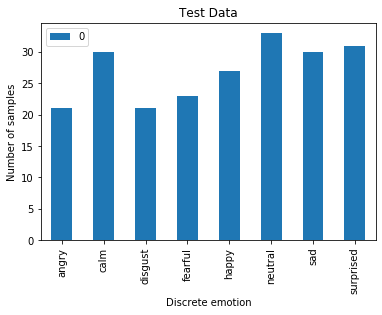

In [14]:
y_test_ct = Counter(y_test.tolist())

keys = [emotions[y] for y in list(y_test_ct.keys())]
data = y_test_ct.values()
keys.sort()
to_plot= pd.DataFrame(data,index=keys)
to_plot.plot.bar()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Test Data")
plt.show()

In [31]:
output_size=len(list(emotions.keys()))

set_hyperparameters = [{"learning_rate": 0.001,
                        "hidden_size": 100,
                        "number_layers": 3,
                        "batch_size": 150,
                        "model": 'model1'
                        },
                       {"learning_rate": 0.001,
                        "hidden_size": 400,
                        "number_layers": 3,
                        "batch_size": 32,
                        "model": 'model2'
                       },
                       {"learning_rate": 0.001,
                        "hidden_size": 250,
                        "number_layers": 2,
                        "batch_size": 64,
                        "model": 'model3'
                       },
                        {"learning_rate": 0.001,
                         "hidden_size": 250,
                         "number_layers": 3,
                         "batch_size": 64,
                         "model": 'model4'
                        },
                       {"learning_rate": 0.001,
                        "hidden_size": 250,
                        "number_layers": 3,
                        "batch_size": 32,
                        "model": 'model5'
                       },
                       {"learning_rate": 0.001,
                        "hidden_size": 250,
                        "number_layers": 2,
                        "batch_size": 32,
                        "model": 'model6'
                       }
                      ]

In [32]:
for hp in set_hyperparameters:
    trainer.train_model(model, x_train, y_train, x_val, y_val, hp, output_size)

model1: Total loss in epoch 99 is: 5.609347820281982      |      F1 score in validation is: 0.483824741016329946
 Finished training model1.
model2: Total loss in epoch 99 is: 6.726911544799805      |      F1 score in validation is: 0.579224225870370145
 Finished training model2.
model3: Total loss in epoch 99 is: 3.3012301921844482      |      F1 score in validation is: 0.55581188779325124
 Finished training model3.
model4: Total loss in epoch 99 is: 4.372063159942627      |      F1 score in validation is: 0.580607492976654396
 Finished training model4.
model5: Total loss in epoch 99 is: 10.805541038513184      |      F1 score in validation is: 0.55338717288142957
 Finished training model5.
model6: Total loss in epoch 99 is: 8.215299606323242      |      F1 score in validation is: 0.570939563100953837
 Finished training model6.


In [33]:
best_model_path = "project_models/model4.pt"

{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
F1 Score: 0.5918671405923217
              precision    recall  f1-score   support

           0       0.60      0.29      0.39        21
           1       0.58      0.68      0.63        31
           2       0.68      0.45      0.55        33
           3       0.67      0.40      0.50        30
           4       0.73      0.70      0.72        27
           5       0.47      0.76      0.58        21
           6       0.49      0.78      0.60        23
           7       0.70      0.77      0.73        30

    accuracy                           0.60       216
   macro avg       0.61      0.60      0.59       216
weighted avg       0.62      0.60      0.59       216



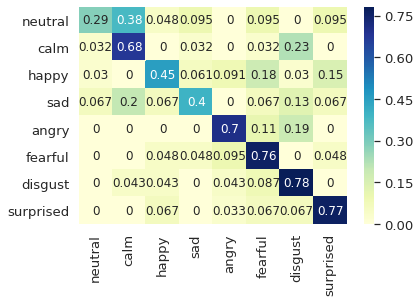

In [34]:
y_pred = trainer.predict(x_test, model, best_model_path)
print(emotions)
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print(classification_report(y_test, y_pred))
cn = confusion_matrix(y_test, y_pred, normalize="true")
df_cm = pd.DataFrame(cn, index = [i for i in emotions.values()],
                  columns = [i for i in emotions.values()])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu") # font size

plt.show()

In [35]:
my_audios = Path("Audio_Merle")
X_merle, y_merle = [], []
for file in my_audios.glob("*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = basename.split(".")[0]
    emotion = int(emotion)-1
    # extract features
    features = extract_feature(file)

    X_merle.append(features)
    y_merle.append(emotion)
    merle_e = [emotions[emotion] for emotion in y_merle]

In [36]:
x = torch.Tensor(X_merle)

In [37]:
y_pred = trainer.predict(x, model, best_model_path)
pred_e = [emotions[emotion] for emotion in y_pred]

In [38]:
for i in range(len(pred_e)):
    print(f'{merle_e[i] == pred_e[i]}      |       correct Label: {merle_e[i]}       |       Prediction: {pred_e[i]}')

False      |       correct Label: surprised       |       Prediction: angry
False      |       correct Label: disgust       |       Prediction: happy
False      |       correct Label: fearful       |       Prediction: happy
False      |       correct Label: sad       |       Prediction: happy
True      |       correct Label: happy       |       Prediction: happy
False      |       correct Label: neutral       |       Prediction: happy
False      |       correct Label: calm       |       Prediction: happy
False      |       correct Label: angry       |       Prediction: happy


{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
F1 Score: 0.03125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.14      1.00      0.25         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.12         8
   macro avg       0.02      0.12      0.03         8
weighted avg       0.02      0.12      0.03         8



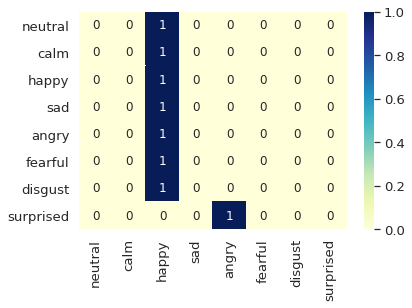

In [39]:
print(emotions)
print("F1 Score:", f1_score(y_merle, y_pred, average="weighted"))
print(classification_report(y_merle, y_pred))
cn = confusion_matrix(y_merle, y_pred, normalize="true")
df_cm = pd.DataFrame(cn, index = [i for i in emotions.values()],
                  columns = [i for i in emotions.values()])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu") # font size

plt.show()

In [40]:
GER_audios = Path("German")

GER_em = {
    "W": 4,
    "E": 6,
    "A": 5,
    "F": 2,
    "T": 3,
    "N": 0
}
X_GER, y_GER = [], []
for file in GER_audios.glob("*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = basename[5]
    if emotion in GER_em.keys():
        emotion = GER_em[emotion] 
        # extract features
        features = extract_feature(file)

        X_GER.append(features)
        y_GER.append(emotion)
    
GER_e = [emotions[emotion] for emotion in y_GER]

In [41]:
x = torch.Tensor(X_GER)
x.shape

torch.Size([454, 180])

In [42]:
y_pred = trainer.predict(x, model, best_model_path)
pred_e = [emotions[emotion] for emotion in y_pred]

{0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'}
F1 Score: 0.1227165171608348
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        62
           4       0.28      1.00      0.44       127
           5       0.00      0.00      0.00        69
           6       0.00      0.00      0.00        46

    accuracy                           0.28       454
   macro avg       0.05      0.17      0.07       454
weighted avg       0.08      0.28      0.12       454



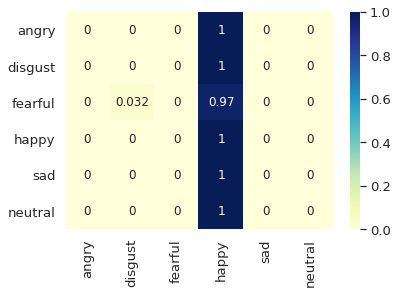

In [43]:
print(emotions)
print("F1 Score:", f1_score(y_GER, y_pred, average="weighted"))
print(classification_report(y_GER, y_pred))
cn = confusion_matrix(y_GER, y_pred, normalize="true")
df_cm = pd.DataFrame(cn, index = [emotions[GER_em[i]] for i in GER_em.keys()],
                  columns = [emotions[GER_em[i]] for i in GER_em.keys()])
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12},cmap="YlGnBu") # font size

plt.show()